In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from evals.video_classification_frozen.eval import make_dataloader
import matplotlib.pyplot as plt
import torch
import yaml
import numpy as np
import torch.nn.functional as F
from app.vjepa.utils import (
    init_video_model,
)
import copy

In [2]:
with open('configs/pretrain/vitl16.yaml', 'r') as y_file:
    args = yaml.load(y_file, Loader=yaml.FullLoader)

# -- set device
if not torch.cuda.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)

# -- META
cfgs_meta = args.get('meta')
use_sdpa = cfgs_meta.get('use_sdpa', False)

# -- MODEL
cfgs_model = args.get('model')
model_name = cfgs_model.get('model_name')
pred_depth = cfgs_model.get('pred_depth')
pred_embed_dim = cfgs_model.get('pred_embed_dim')
uniform_power = cfgs_model.get('uniform_power', True)
use_mask_tokens = cfgs_model.get('use_mask_tokens', True)
zero_init_mask_tokens = cfgs_model.get('zero_init_mask_tokens', True)

# -- MASK
cfgs_mask = args.get('mask')

# -- DATA
cfgs_data = args.get('data')
dataset_type = cfgs_data.get('dataset_type', 'videodataset')
mask_type = cfgs_data.get('mask_type', 'multiblock3d')
dataset_paths = cfgs_data.get('datasets', [])
datasets_weights = cfgs_data.get('datasets_weights', None)
if datasets_weights is not None:
    assert len(datasets_weights) == len(dataset_paths), 'Must have one sampling weight specified for each dataset'
batch_size = cfgs_data.get('batch_size')
batch_size = 1
num_clips = cfgs_data.get('num_clips')
num_frames = cfgs_data.get('num_frames')
tubelet_size = cfgs_data.get('tubelet_size')
sampling_rate = cfgs_data.get('sampling_rate')
duration = cfgs_data.get('clip_duration', None)
crop_size = cfgs_data.get('crop_size', 224)
patch_size = cfgs_data.get('patch_size')
pin_mem = cfgs_data.get('pin_mem', False)
num_workers = cfgs_data.get('num_workers', 1)
filter_short_videos = cfgs_data.get('filter_short_videos', False)
decode_one_clip = cfgs_data.get('decode_one_clip', True)
log_resource_util_data = cfgs_data.get('log_resource_utilization', False)

eval_num_segments = 1
attend_across_segments = False
world_size = 1
rank = 0

In [3]:
train_data_path = ['lol.csv']
# train_data_path = ['/storage_bizon/naravich/Unlabeled_OCT_videos/Unlabel_OCT_Video.csv']
data_loader = make_dataloader(
        dataset_type=dataset_type,
        root_path=train_data_path,
        resolution=crop_size,
        frames_per_clip=num_frames,
        frame_step=sampling_rate,
        eval_duration=duration,
        num_segments=eval_num_segments if attend_across_segments else 1,
        num_views_per_segment=1,
        allow_segment_overlap=True,
        batch_size=batch_size,
        world_size=world_size,
        rank=rank,
        training=False)

for data in data_loader:
    clips, masks_enc, masks_pred = data
    break

INFO:root:VideoDataset dataset created
INFO:root:VideoDataset unsupervised data loader created


0.0 1.0


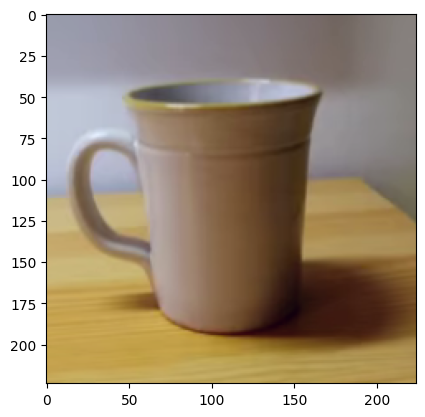

In [4]:
clips[0][0].shape
min_val = clips[0][0][0].permute(1, 2, 3, 0)[0].numpy().min()
max_val = clips[0][0][0].permute(1, 2, 3, 0)[0].numpy().max()
img = (clips[0][0][0].permute(1, 2, 3, 0)[0].numpy() - min_val) / (max_val - min_val)
print(img.min(), img.max())
plt.imshow(img)

In [5]:
encoder, predictor = init_video_model(
    uniform_power=uniform_power,
    use_mask_tokens=use_mask_tokens,
    num_mask_tokens=len(cfgs_mask),
    zero_init_mask_tokens=zero_init_mask_tokens,
    device=device,
    patch_size=patch_size,
    num_frames=num_frames,
    tubelet_size=tubelet_size,
    model_name=model_name,
    crop_size=crop_size,
    pred_depth=pred_depth,
    pred_embed_dim=pred_embed_dim,
    use_sdpa=use_sdpa,
)

INFO:root:MultiMaskWrapper(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed3D(
      (proj): Conv3d(3, 1024, kernel_size=(2, 16, 16), stride=(2, 16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=Tr

In [6]:
with torch.no_grad():
    x = encoder.backbone(clips[0][0].to(device))

output_of_vjepa = x
print('output_of_vjepa:', x.shape)
print('input shape:', clips[0][0].shape)

B, N, D = x.shape
B, C, FRAMES, H, W = clips[0][0].shape
# Patch = (tubelet_size, patch_size, patch_size)
N_FRAMES = FRAMES // tubelet_size
N_H = H // patch_size
N_W = W // patch_size

print(f'Thus, N feature ({output_of_vjepa.shape[1]}) is calcuated from', H * W * FRAMES / tubelet_size / patch_size / patch_size)

output_of_vjepa: torch.Size([1, 1568, 1024])
input shape: torch.Size([1, 3, 16, 224, 224])
Thus, N feature (1568) is calcuated from 1568.0


/home/naravich/.conda/envs/jepa/lib/python3.9/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


In [8]:

from src.models.attentive_pooler import AttentiveSegmentator
from torch import nn

In [21]:
encoder.backbone.embed_dim, encoder.backbone.embed_dim

(1024, 1024)

In [25]:
decoder = AttentiveSegmentator(
    img_size=encoder.backbone.input_size,
    patch_size=encoder.backbone.patch_size,
    num_frames=encoder.backbone.num_frames,
    tubelet_size=encoder.backbone.tubelet_size,
    encoder_embed_dim=encoder.backbone.embed_dim,
    decoder_embed_dim=768,
    depth=1, 
    num_heads=12, 
    mlp_ratio=4.0, 
    qkv_bias=True, 
    qk_scale=None, 
    drop_rate=0.0, 
    attn_drop_rate=0.0,
    norm_layer=nn.LayerNorm,
    init_std=0.02, 
    num_classes=2, 
).cuda()
with torch.no_grad():
    x = decoder(x)

/home/naravich/.conda/envs/jepa/lib/python3.9/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


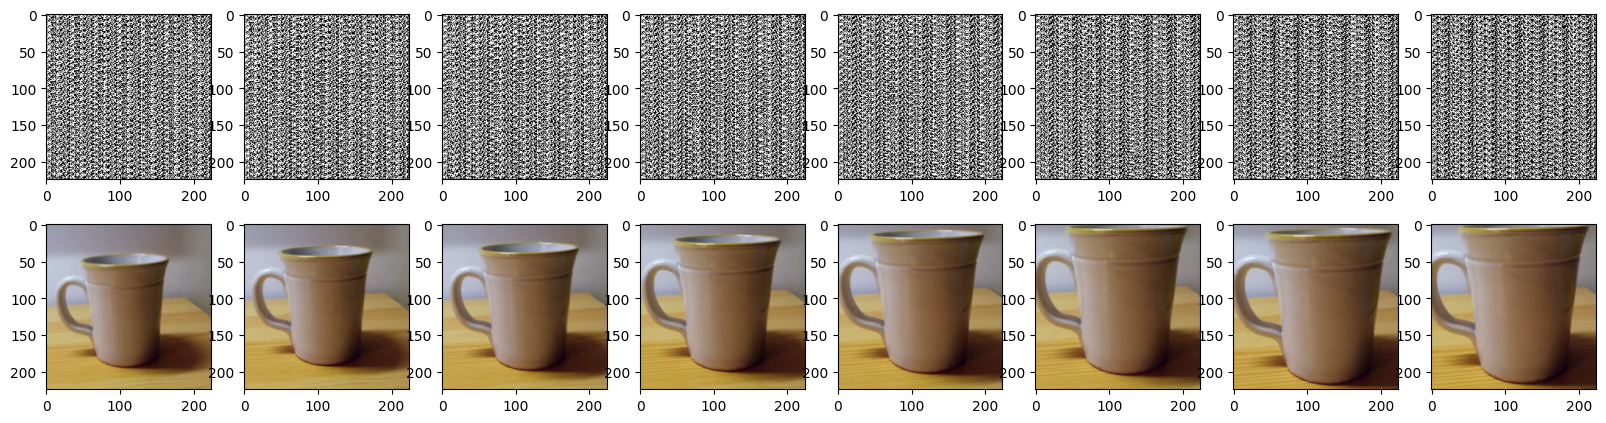

In [47]:
segmentation = x.reshape(B, N_FRAMES, N_H, N_W, patch_size, patch_size, 2).detach().cpu().numpy()

axes, fig = plt.subplots(2, 8, figsize=(20, 5))

for clip_index in range(8):
    segmentation = (segmentation - segmentation.min()) / (segmentation.max() - segmentation.min())
    segmentation = segmentation.reshape(B, N_FRAMES, N_H*patch_size, N_W*patch_size, 2)
    fig[0, clip_index].imshow(np.argmax(segmentation[0, clip_index, :, :, :], axis=-1), cmap='gray')

for clip_index in range(8):
    image = clips[0][0][0].permute(1, 2, 3, 0)[clip_index].numpy()
    image = (image - image.min()) / (image.max() - image.min())
    fig[1, clip_index].imshow(image)

In [48]:
np.unique(np.argmax(segmentation[0, clip_index, :, :, :], axis=-1))

array([0, 1])